In [1]:
### Import libraries and set plot style

import numpy as np
from scipy.optimize import curve_fit
from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.transforms as trans
colors = ['#202020', '#d62728', '#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd', '#bcbd22', '#e377c2', '#17becf', '#1f5a0a', '#8c564b', '#7f7f7f']
         ## black    red        blue       green      orange     violet     yellow     pink       lightblue  darkgreen  dirty-red  grey
plt.rcParams.update({'font.size': 15.5,
                     'axes.titlepad': 25,
                     'axes.labelpad': 20,
                     'axes.labelsize': 20,
                     'xtick.labelsize' : 15.5,
                     'ytick.labelsize' : 15.5,
                     'axes.prop_cycle': cycler('color', colors),
                     #'axes.grid': True,
                     'axes.linewidth': 0.5,
                     'lines.linewidth': 1.5,
                     'lines.markersize': 5,
                     'scatter.marker': 'o',
                     #'errorbar.capsize': 2,
                     'figure.dpi': 100.0,
                     'figure.figsize': [8, 5],
                     'xtick.top' : True,
                     'ytick.right' : True,
                     'xtick.direction' : 'out',
                     'ytick.direction' : 'out',
                     'xtick.major.size': 8,
                     'xtick.minor.size': 3,
                     'ytick.major.size': 8,
                     'ytick.minor.size': 3,
                     'xtick.major.width': 1,
                     'xtick.minor.width': 0.5,
                     'ytick.major.width': 1,
                     'ytick.minor.width': 0.5})

In [2]:
### Import raw data and define measurement specifications

SAMPLE = "20-PEI"
SAMPLE_SHORT = SAMPLE[:2]
# specify what temperatures where used and in what order
TEMPS = [70, 50, 30]
GASES = ["N$_2$", "CO$_2$"]
# specify which gas is used in which run: N_2 -> 0, CO_2 -> 1 (specified in "GASES")
# rows: measurements with fixed temperature, same order as "TEMPS" above
# columns: runs
# (compatability) the same gas may be used twice in a row
S = [[1, 0, 1, 0],
     [1, 0, 1, 0],
     [0, 1, 0, 1, 0]]
# ignore these runs: unusable / redundant data
id_out = ["50-0"]
# specify the starting times of the runs
# sometimes the measurement doesn't start at t=0: set GASCHANGE[0] to cut out degassing phase, otherwise set 0 as first value
# After that, put time in seconds for every time the gas is changed (or new ballon with same gas)
GASCHANGE = [[0, 6989, 16205, 25988],
             [1.8848e+04, 19289, 25645, 33843],
             [7.0136e+03, 10697, 18196, 25623, 32600]]
# columns (indices) of frequency, epsilon' (er), epsilon'' (ei) and time in ascii file
f_col, er_col, ei_col, t_col = 0, 2, 3, -1

# specify folder and filenames of raw data, files in same order as "TEMPS" above
folder = "raw data PEI20/"
results_folder = "results20"
files = ["13-10_M2_TBD031_PEI20_70C_CNCN.TXT",
         "13-13_M1_TBD031_PEI20_50C_NdryCNCN.TXT",
         "13-14_M2_TBD031_PEI20_30C_NdryCNCN.TXT"]
DATA = [[], [], []]

for m, f in enumerate(files) :
     # import ascii data, usually it has a header of 4 lines that is cut out
     data_ = np.genfromtxt(folder+f, delimiter='\t', skip_header=4)

     # remove points before start of first run
     after = data_[:,-1] >= GASCHANGE[m][0]
     data = data_[after]

     # add final time to GASCHANGE, needed in main and make time unit hours
     GASCHANGE[m].append(data[-1,-1])
     GASCHANGE[m] = np.array(GASCHANGE[m]) / 60.
     data[:,-1] = data[:,-1] / 60.

     DATA[m] = data

In [3]:
### Data processing

def gradient_matrix(y, x) :
    # y is a 2D array of shape (m,n) and x a vector of shape m
    # froms forward gradient of every column of y along x
    # accounts for in-between nans in y
    # returns two matrices of shape (m-1,n)
    # one for dy[:,k]/dx and one for the corresponding x values x[:,k] that depend on where nans were found

    m, n = y.shape
    y_der = np.full((m - 1, n), np.nan)
    x_der = np.full((m - 1, n), np.nan)

    for k in range(n):
        notnan = ~np.isnan(y[:, k])
        y_k = y[notnan, k]
        x_k = x[notnan]

        if len(y_k) >= 2:
            dy = y_k[1:] - y_k[:-1]
            dx = x_k[1:] - x_k[:-1]
            valid = dx != 0

            y_der_k = dy[valid] / dx[valid]
            x_der_k = 0.5 * (x_k[1:][valid] + x_k[:-1][valid])

            m_k = len(y_der_k)
            y_der[:m_k, k] = y_der_k
            x_der[:m_k, k] = x_der_k

    return y_der, x_der
    

f_out = [5e5] # ignore data of these frequencies
def extract_interpolate_and_derivative(data, num_points=0):
    """
    Extracts lists x_k for every measured data x at a fixed frequency k
    Creates a universal test set of time points
    Interpolates every fixed-frequency data set for those time points
    Computes derivative epsilon'_der along frequency axis
    """
    
    # Extract unique F_k values
    # ignore frequencies specified in f_out
    unique_f = np.unique(data[:, f_col])
    mask = ~np.isin(unique_f, f_out)
    unique_f = unique_f[mask]
    lnw = np.log(2*np.pi*unique_f)  # Compute ln(omega)
    
    # find time boundaries of data
    # and generate `num_points` equidistant t_i values
    initial_test_t, final_test_t = np.min(data[:,t_col])-0.2, np.max(data[:,t_col])-0.2
    if not num_points:
        num_points = int((final_test_t - initial_test_t) *2)
    t_test_set = np.linspace(initial_test_t, final_test_t, num_points)

    # er: real part of epsilon; ei: imag. part; t: corresponding measured time
    er_int, ei_int = [], []
    # Group er_k and ei_k based on unique F_k
    # unify to test times by interpolation
    for f_k in unique_f:
        mask = data[:, f_col] == f_k
        t_k = data[mask][:, t_col]
        er_k = data[mask][:, er_col]
        ei_k = data[mask][:, ei_col]

        er_int_k = np.interp(t_test_set, t_k, er_k, left=np.nan, right=np.nan)
        ei_int_k = np.interp(t_test_set, t_k, ei_k, left=np.nan, right=np.nan)
        
        er_int.append(er_int_k)
        ei_int.append(ei_int_k)

    er_int = np.array(er_int)
    ei_int = np.array(ei_int)


    # Compute gradient of er_k along ln(omega)
    er_der, lnw_der =  gradient_matrix(er_int, lnw)
    er_der = -np.pi/2 * er_der
    #er_der =  -np.pi/2 * np.gradient(er_int, lnw, axis=0)

    return unique_f, lnw_der.T, er_der.T, ei_int.T, t_test_set

/tmp/ipykernel_125348/3804793551.py:24: RuntimeWarning: invalid value encountered in log
  ln_er_der = np.log(er_der)
/tmp/ipykernel_125348/3804793551.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])
/tmp/ipykernel_125348/3804793551.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_yticks()])


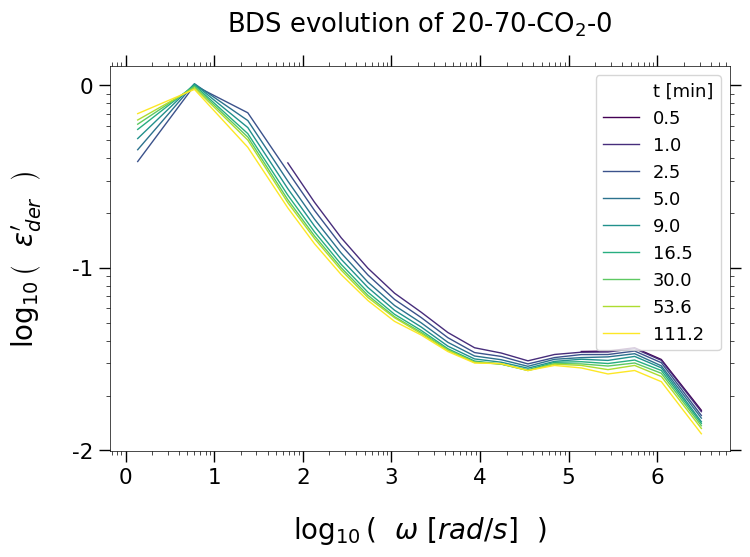

/tmp/ipykernel_125348/3804793551.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])
/tmp/ipykernel_125348/3804793551.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_yticks()])


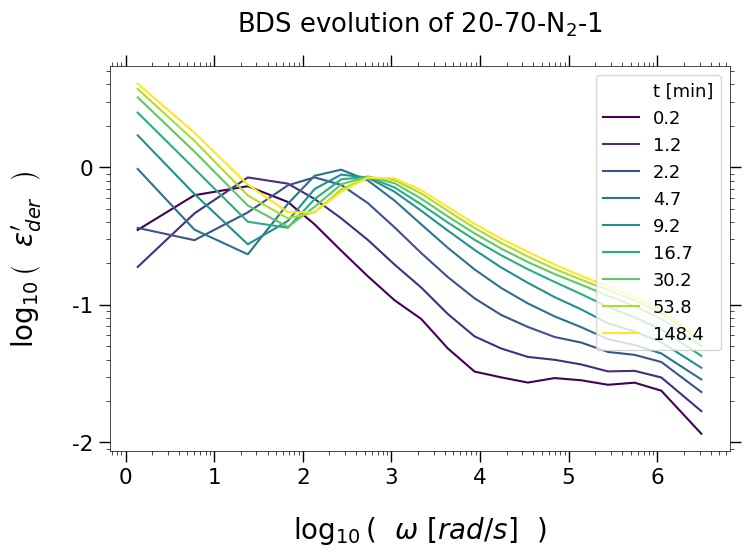

/tmp/ipykernel_125348/3804793551.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])
/tmp/ipykernel_125348/3804793551.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_yticks()])


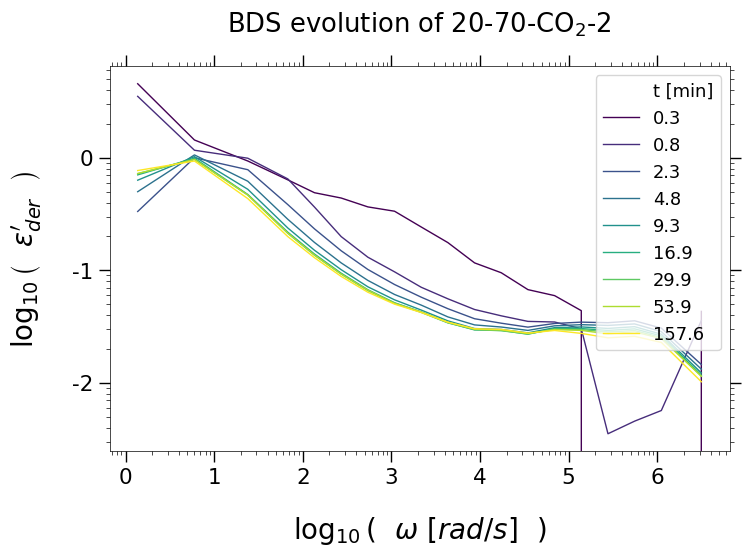

/tmp/ipykernel_125348/3804793551.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])
/tmp/ipykernel_125348/3804793551.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_yticks()])


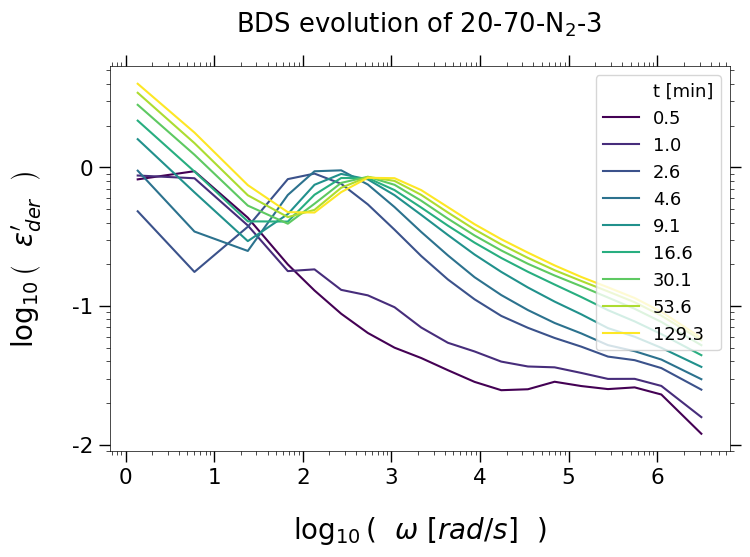

/tmp/ipykernel_125348/3804793551.py:24: RuntimeWarning: invalid value encountered in log
  ln_er_der = np.log(er_der)
/tmp/ipykernel_125348/3804793551.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])
/tmp/ipykernel_125348/3804793551.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_yticks()])


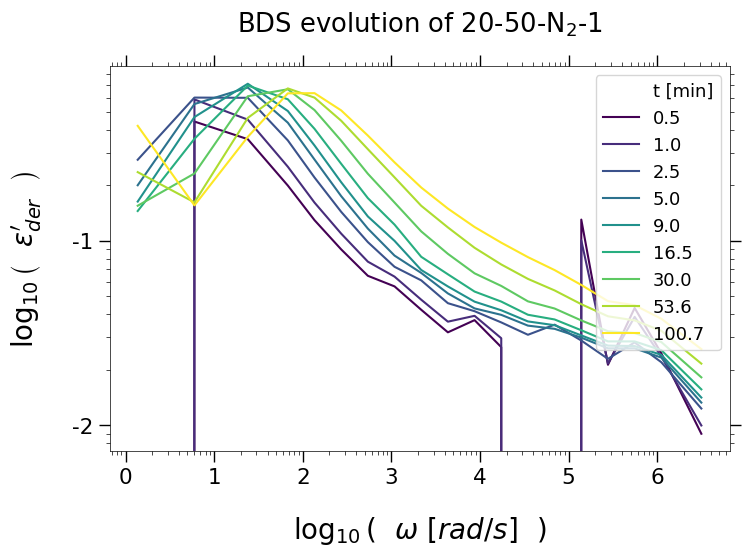

/tmp/ipykernel_125348/3804793551.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])
/tmp/ipykernel_125348/3804793551.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_yticks()])


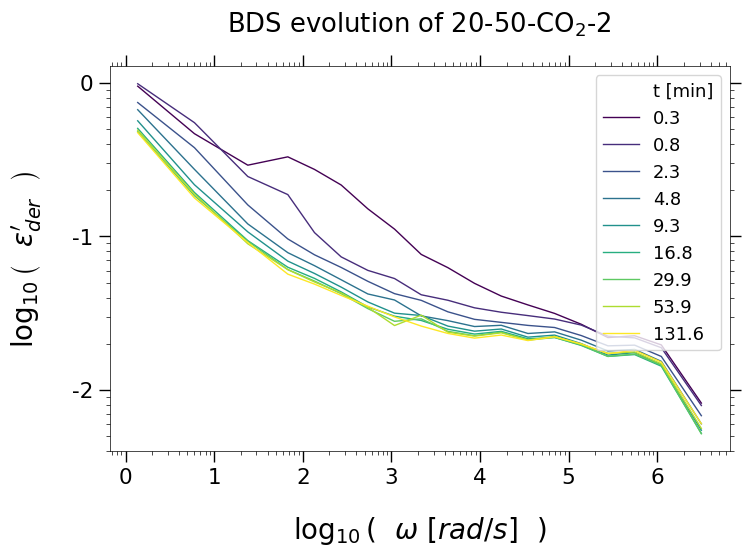

/tmp/ipykernel_125348/3804793551.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])
/tmp/ipykernel_125348/3804793551.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_yticks()])


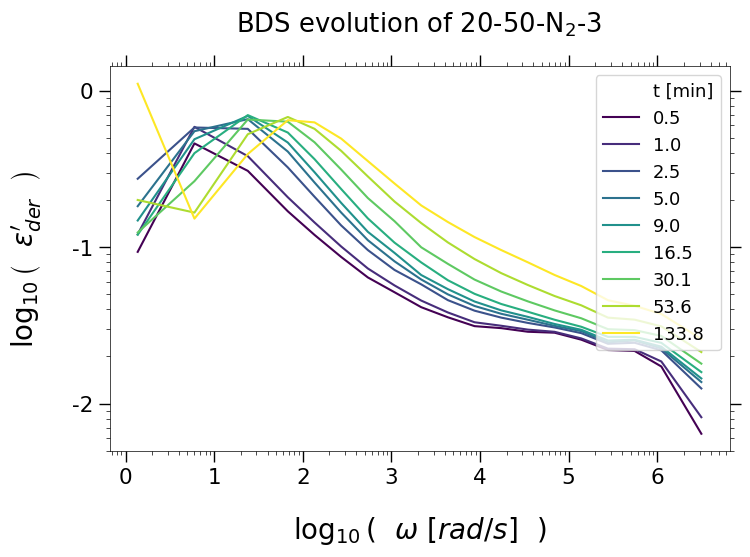

/tmp/ipykernel_125348/3804793551.py:24: RuntimeWarning: invalid value encountered in log
  ln_er_der = np.log(er_der)
/tmp/ipykernel_125348/3804793551.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])
/tmp/ipykernel_125348/3804793551.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_yticks()])


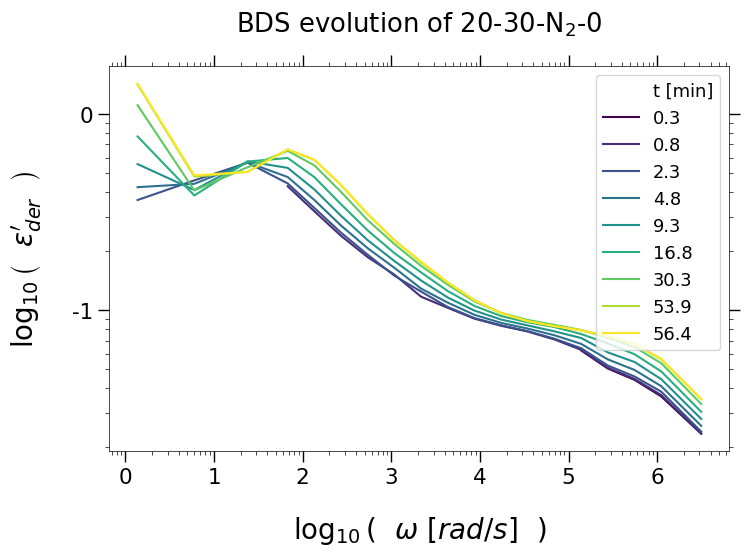

/tmp/ipykernel_125348/3804793551.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])
/tmp/ipykernel_125348/3804793551.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_yticks()])


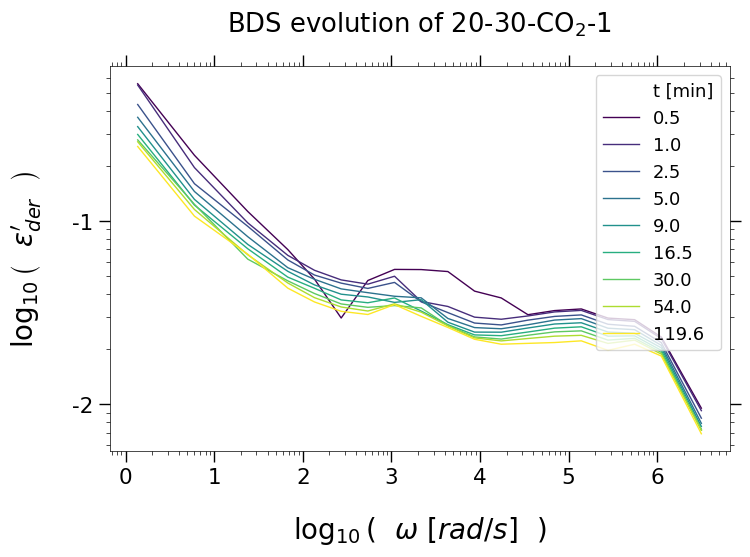

/tmp/ipykernel_125348/3804793551.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])
/tmp/ipykernel_125348/3804793551.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_yticks()])


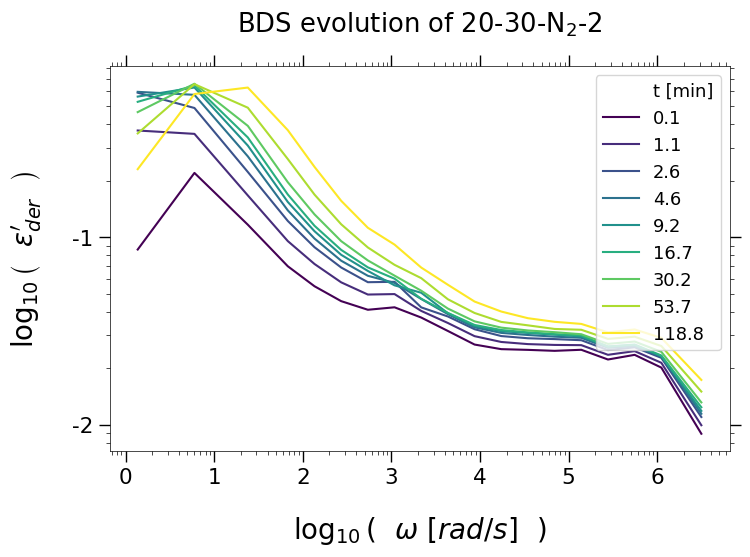

/tmp/ipykernel_125348/3804793551.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])
/tmp/ipykernel_125348/3804793551.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_yticks()])


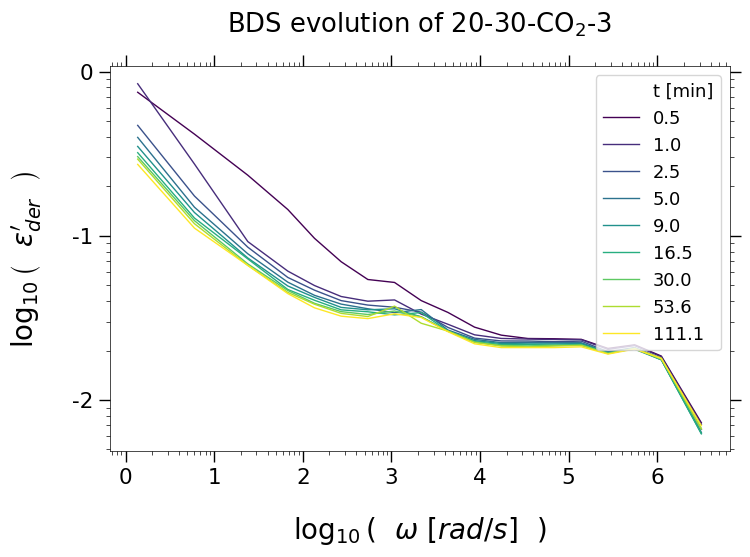

/tmp/ipykernel_125348/3804793551.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])
/tmp/ipykernel_125348/3804793551.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_yticks()])


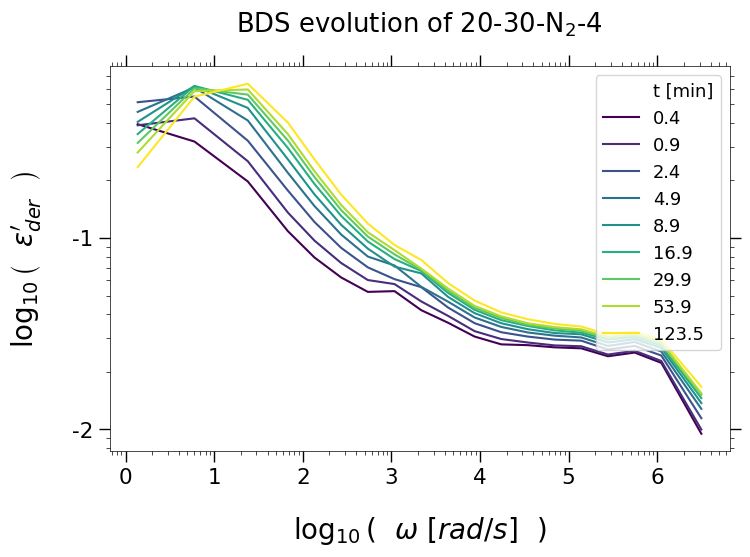

In [4]:
### main

ID = []
# ignore these runs
id_out = ["50-0"]
title_text = "BDS evolution of "
# selection of a few indices where the plot is shown; quadratic: show many at the start and less later
plotI = np.linspace(0,4,8)
plottimes = np.exp( plotI )-1
plottimes = np.append(plottimes, [1e5, 1e5])
tol = 5


# go throgh all temperatures, or rather their respective datasets
for m, data in enumerate(DATA) :
    temp = str(TEMPS[m])

    # f is an array of the unique frequencies
    # er_der is a 2D array of all "numerical derivative of real part"-values
    # er_der[i] (one row of the matrix) is one spectrum
    # where i (one column) corresponds to the time
    # The array contains a whole measurement with fixed temperature and all gas runs
    f, lnw_der, er_der, ei, t = extract_interpolate_and_derivative(data)
    ln_er_der = np.log(er_der)
    w = 2*np.pi*f
    lnw = np.log(w)
    w_der = np.exp(lnw_der)
    
    # go throgh all runs, one run starts with change of gas
    for j, t0 in enumerate(GASCHANGE[m][:-1]) :
        if temp+'-'+str(j) in id_out :
            continue
        gas = GASES[S[m][j]]
        ID.append(temp+'-'+gas+'-'+str(j))
        run_num = len(ID) - 1

        t1 = GASCHANGE[m][j+1]-tol
        # indices of start/end of current run
        t0_i = np.searchsorted(t, t0, side="left")
        t1_i = np.searchsorted(t, t1, side="right")
        ploti = 0


        plt.xscale('log')
        plt.yscale('log')
        plt.plot([],[],color='white',label="t [min]")

        for i in range(t0_i, t1_i) :
            # time relative to change of gas (=start of current run)
            dt = t[i]-t0
            dt = np.round(dt, 1)


            # plot a small selection of spectra
            if dt > plottimes[ploti] or i==t1_i-1 :
                color = plt.cm.viridis(ploti / len(plotI))  
                if gas[0] == 'C' :  
                    plt.plot(w_der[i], er_der[i], label=str(dt), color=color, lw=1)
                else :
                    plt.plot(w_der[i], er_der[i], label=str(dt), color=color)
                plt.ylabel("$\\log_{10}\\left(~~ \\epsilon_{der}' ~~\\right)$")
                ploti += 1

        ax = plt.gca()
        ax.set_xticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_xticks()])
        ax.set_yticklabels([int(np.log10(tick)) if tick > 0 else '' for tick in ax.get_yticks()])

        title = title_text + SAMPLE_SHORT +'-'+ ID[-1]
        plt.title(title)
        plt.xlabel("$\\log_{10}(~~ \\omega ~[rad/s] ~~)$")

        plt.legend(fontsize='small', loc='upper right')
        #plt.savefig(results_folder+"/specevo/"+ID[-1]+".pdf", bbox_inches='tight')
        plt.show()

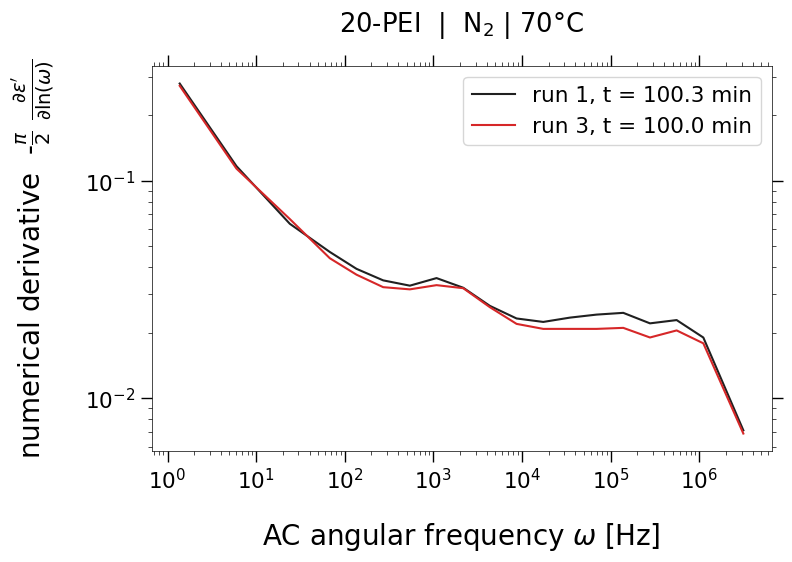

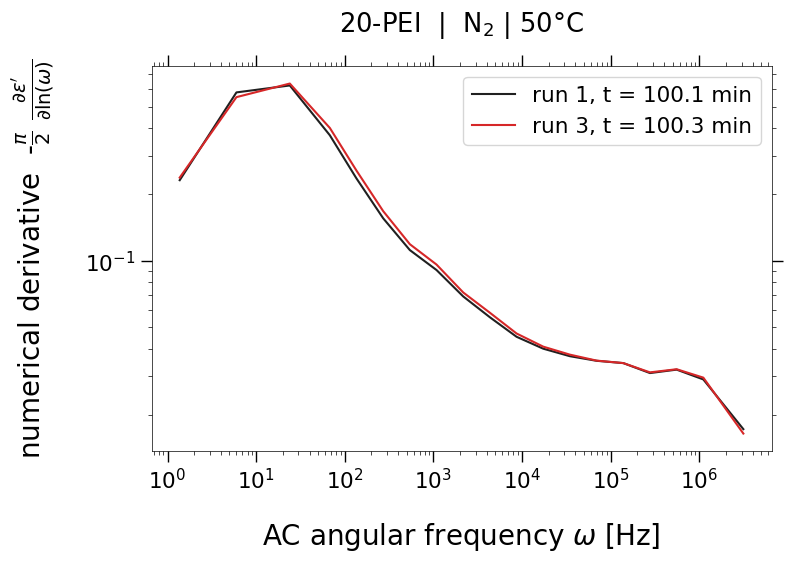

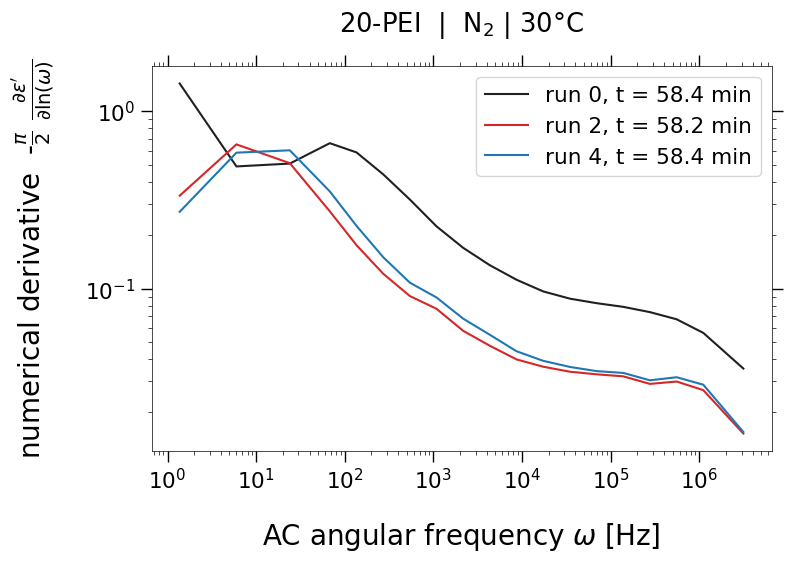

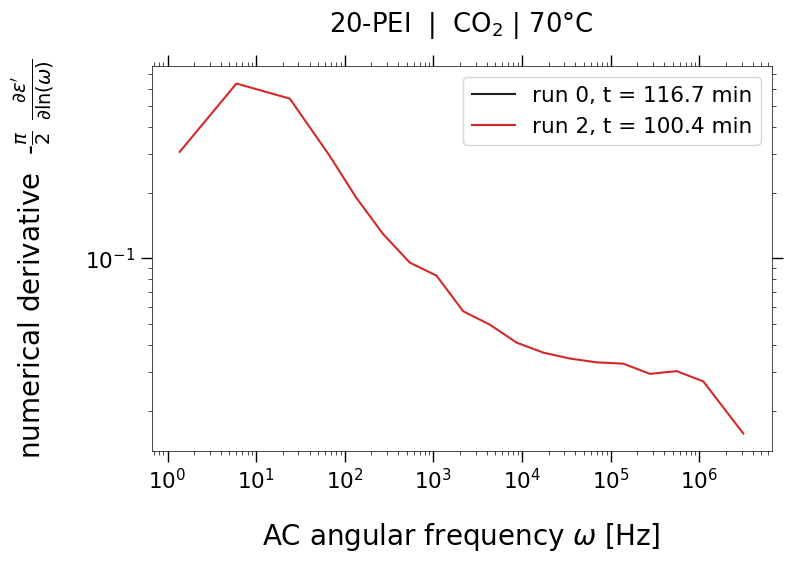

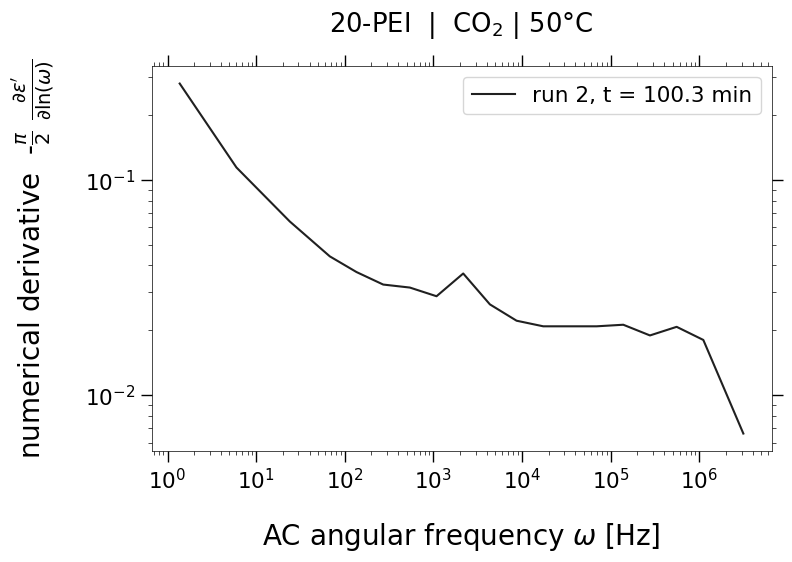

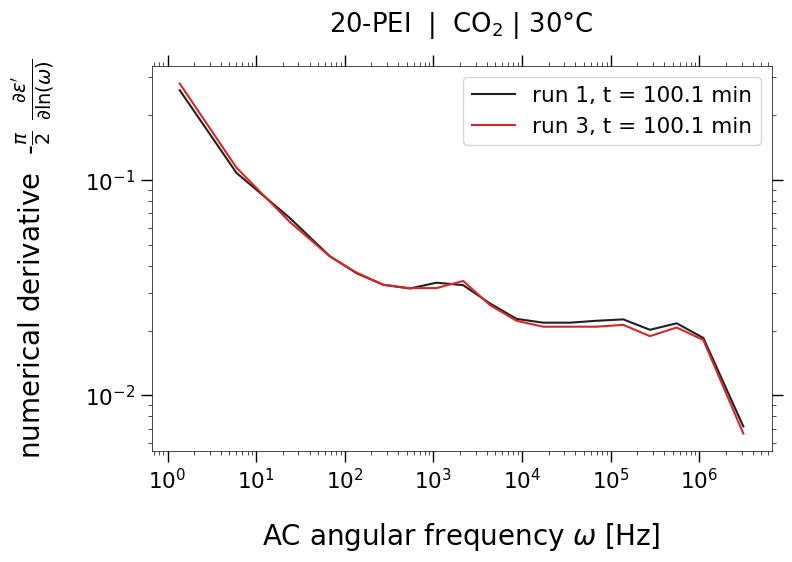

In [5]:
### main

# ignore these runs: "tr", where t represents the temperature ({0, 1, 2} -> {70, 50, 30})  and r is the number of the run
idOut = ["10"]
tol = 2e-2


# go throgh all temperatures, or rather their respective datasets
for g in GASES :
    for m, data in enumerate(DATA) :
        temp = str(TEMPS[m])
        
        # go throgh all runs, one run starts with change of gas
        for j, t0 in enumerate(GASCHANGE[m][:-1]) :
            if str(m)+str(j) in idOut :
                continue
            gas = GASES[S[m][j]]
            if gas != g :
                continue
            
            if g[0] == "N" and temp[0] == "3" :
                plot_t = 58
            else :
                plot_t = 100

            t1 = t0 + plot_t
            t1_i = np.searchsorted(t, t1, side="left")

            plt.xscale('log')
            plt.yscale('log')

            t_str = str(np.round(t[t1_i]-t0, 1))
            label = "run " + str(j) + ", t = " + t_str + " min"
            plt.plot(w_der[i], er_der[t1_i], label=label)
            plt.ylabel("numerical derivative  -$\\frac{\\pi}{2} ~ \\frac{\\partial\\epsilon'}{\\partial\\ln(\\omega)}$")
            #if i==80 :
            #    plt.savefig("results20/"+ID[-1], dpi='figure')


        title = SAMPLE + "  |  "+ g +" | " + temp + "°C"
        plt.title(title)
        plt.xlabel("AC angular frequency $\omega$ [Hz]")

        plt.legend()
        #plt.savefig("runcomp/" + g + "-" + temp, bbox_inches='tight')
        plt.show()